The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Natural Language Inference: Fine-Tuning BERT

:label:`sec_natural-language-inference-bert`


In earlier sections of this chapter,
we have designed an attention-based architecture
(in :numref:`sec_natural-language-inference-attention`)
for the natural language inference task
on the SNLI dataset (as described in :numref:`sec_natural-language-inference-and-dataset`).
Now we revisit this task by fine-tuning BERT.
As discussed in :numref:`sec_finetuning-bert`,
natural language inference is a sequence-level text pair classification problem,
and fine-tuning BERT only requires an additional MLP-based architecture,
as illustrated in :numref:`fig_nlp-map-nli-bert`.

![This section feeds pretrained BERT to an MLP-based architecture for natural language inference.](../img/nlp-map-nli-bert.svg)

:label:`fig_nlp-map-nli-bert`


In this section,
we will pretrain a small version of BERT,
then fine-tune the pretrained BERT model
for natural language inference on the SNLI dataset.


## Pretraining BERT

We have explained how to pretrain BERT on the WikiText-2 dataset in
:numref:`sec_bert-dataset` and :numref:`sec_bert-pretraining`
(note that the original BERT model is pretrained on much bigger corpora).
In the following,
we load the WikiText-2 dataset as minibatches
of pretraining examples with the batch size being 512
and the maximum length of a BERT input sequence being 128.

In [1]:
import d2l
import multiprocessing
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len = 512, 128
bert_train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

As discussed in :numref:`sec_bert-pretraining`,
the original BERT model has hundreds of millions of parameters.
To facilitate demonstration,
we define a small BERT of 2 layers, 128 hidden units, and 2 self-attention heads.
We pretrain BERT on the WikiText-2 dataset for 3,000 iteration steps.

MLM loss 5.595, NSP loss 0.283
9794.0 sentence pairs/sec on [gpu(0), gpu(1)]


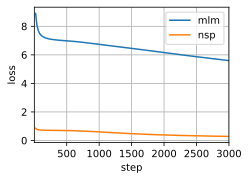

In [2]:
ctx, loss = d2l.try_all_gpus(), gluon.loss.SoftmaxCELoss()
bert = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=128,
                     num_heads=2, num_layers=2, dropout=0.2)
bert.initialize(init.Xavier(), ctx=ctx)
d2l.train_bert(bert_train_iter, bert, loss, len(vocab), ctx, 20, 3000)

## The Dataset for Fine-Tuning BERT

For the downstream task natural language inference on the SNLI dataset,
we define a customized dataset class `SNLIBERTDataset`.
In each example,
the premise and hypothesis form a pair of text sequence
and is packed into one BERT input sequence as depicted in :numref:`fig_bert-two-seqs`.
Recall :numref:`subsec_bert_input_rep` that segment IDs
are used to distinguish the premise and the hypothesis in a BERT input sequence.
With the predefined maximum length of a BERT input sequence (`max_len`),
the last token of the longer of the input text pair keeps getting removed until
`max_len` is met.
To accelerate generation of the SNLI dataset
for fine-tuning BERT,
we use 4 worker processes to generate training or testing examples in parallel.

In [3]:
class SNLIBERTDataset(gluon.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            d2l.tokenize(dataset[0]), d2l.tokenize(dataset[1]))]
        self.labels = np.array(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (np.array(all_token_ids, dtype='int32'),
                np.array(all_segments, dtype='int32'), 
                np.array(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

After downloading the SNLI dataset,
we generate training and testing examples
by instantiating the `SNLIBERTDataset` class.
Such examples will be read in minibatches during training and testing
of natural language inference.

In [4]:
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
batch_size, num_workers = 512, d2l.get_dataloader_workers()
train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples


read 9824 examples


## Fine-Tuning BERT

As :numref:`fig_bert-two-seqs` indicates,
fine-tuning BERT for natural language inference
requires only an extra MLP consisting of two fully-connected layers.
This MLP transforms the
BERT representation of the special “&lt;cls&gt;” token,
which encodes the information of both the premise and the hypothesis,
into three outputs of natural language inference:
entailment, contradiction, and neutral.

In [5]:
class BERTClassifier(nn.Block):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.classifier = nn.Sequential()
        self.classifier.add(nn.Dense(256, activation='relu'))
        self.classifier.add(nn.Dense(3))

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X, _, _ = self.bert(tokens_X, segments_X, valid_lens_x)
        return self.classifier(encoded_X[:, 0, :])

In the following,
the pretrained BERT model `bert` becomes part of the model (`net`) for
the downstream application.
However, only the parameters of the additional MLP (`net.classifier`) will be learned from scratch.
All the parameters of the pretrained BERT will be fine-tuned.

In [6]:
net = BERTClassifier(bert)
net.classifier.initialize(ctx=ctx)

Recall that
in :numref:`sec_bert`
both the `MaskLM` class and the `NextSentencePred` class
have parameters in their employed MLPs.
These parameters are part of those in the pretrained BERT model
`bert`, and thus part of parameters in `net`.
However, these parameters are only for computing
the masked language modeling loss
and the next sentence prediction loss
during pretraining.
These two loss functions are irrelevant to fine-tuning downstream applications,
thus the parameters of the employed MLPs in 
`MaskLM` and `NextSentencePred` are not updated (staled) when BERT is fine-tuned.

To allow parameters with stale gradients,
the flag `ignore_stale_grad=True` is set in the `step` function of `d2l.train_batch_ch13`.
We use this function to train and evaluate the model `net` using the training set
(`train_iter`) and the testing set (`test_iter`) of SNLI.
Due to the limited computational resources, pretraining corpora,
and training time, the training and testing accuracy
can be further improved: we leave its discussions in the exercises.

loss 0.885, train acc 0.574, test acc 0.555
11128.2 examples/sec on [gpu(0), gpu(1)]


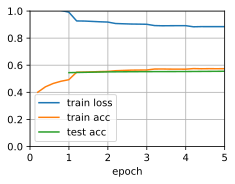

In [7]:
lr, num_epochs = 1e-4, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx,
               d2l.split_batch_multi_inputs)

## Summary

* We can pretrain BERT and fine-tune the pretrained BERT model for downstream applications, such as natural language inference on the SNLI dataset.
* During fine-tuning, the BERT model becomes part of the model for the downstream application. Parameters that are only related to pretraining loss will not be updated during fine-tuning. 


## Exercises

1. How to truncate a pair of sequences according to their ratio of length? Compare this pair truncation method and the one used in the `SNLIBERTDataset` class. What are their pros and cons?
2. If your computational resource allows, increase the model size such as setting `ffn_num_hiddens=256`, `num_heads=4`, and `num_layers=4`. By increasing pretraining steps and fine-tuning epochs (and possibly tuning other hyperparameters), can you get a testing accuracy higher than 0.75? Improve the sentence splitting technique by using those as described in the exercises of :numref:`sec_bert-dataset`. Does it lead to better testing accuracy?
3. If your computational resource allows, use a much larger pretraining corpus and a much larger BERT. Can you get a much better testing accuracy? How long do the pretraining and fine-tuning take?


## [Discussions](https://discuss.mxnet.io/t/5870)

![](../img/qr_natural-language-inference-bert.svg)